In [26]:

# Idea:
# Get every edge into a dataframe to allow you to sort and assess
# Evaluate missing edge distances as well as correct edge distances to set relic threshold
# 100+ edges maybe incorrect because of forced inclusion - lets try to reduce that


In [27]:
from relic.graphs.graphs import get_precision_recall, draw_graph
import pandas as pd
import networkx as nx

In [31]:
workflow_ids = ['real', '1','2','3','4','5','6']
base_dir = '/home/suhail/Scratch/ratiogen/'

def get_edge_type_df(edge_list, gt_tag, inferred_tag, wf_id):
    return_df = pd.DataFrame(
        pd.Series(edge_list), columns=['edge'])
    return_df['ground_truth'] = gt_tag
    return_df['inferred'] = inferred_tag
    return_df['wf_id'] = wf_id
    return return_df
    

all_results = []
result_df = pd.DataFrame()
for i in workflow_ids:
    gt_file = f"{base_dir}/{i}/combined_gt_fixed.pkl"
    relic_result = f"{base_dir}/{i}/inferred_graph.csv"
    gt_graph = nx.read_gpickle(gt_file)
    print(f"Workflow {i}, Nodes: {len(gt_graph.nodes())}, Edges: {len(gt_graph.edges())}, Components {nx.number_connected_components(gt_graph.to_undirected())}")
    inferred_graph = nx.read_edgelist(relic_result)
    result_dict = get_precision_recall(gt_graph, inferred_graph)
    all_results.append(result_dict)
    print(len(result_dict['correct_edges']),len(result_dict['to_remove']),len(result_dict['to_add']))
    print(result_dict['F1'],result_dict['Precision'],result_dict['Recall'])
    result_df = result_df.append(get_edge_type_df(list(result_dict['correct_edges']), True, True, i), ignore_index=False)
    result_df = result_df.append(get_edge_type_df(list(result_dict['to_add']), True, False, i), ignore_index=False)
    result_df = result_df.append(get_edge_type_df(list(result_dict['to_remove']), False, True, i), ignore_index=False)

    

Workflow real, Nodes: 135, Edges: 125, Components 11
112 5 13
0.9256198347107438 0.9572649572649573 0.896
Workflow 1, Nodes: 2271, Edges: 2171, Components 100
1648 556 523
0.7533714285714286 0.7477313974591652 0.7590971902349147
Workflow 2, Nodes: 2194, Edges: 2094, Components 100
1527 610 567
0.7218151737177972 0.7145531118390267 0.7292263610315186
Workflow 3, Nodes: 2134, Edges: 2034, Components 100
1526 550 508
0.7425790754257908 0.7350674373795761 0.7502458210422812
Workflow 4, Nodes: 2395, Edges: 2295, Components 100
1680 696 615
0.7193320488118176 0.7070707070707071 0.7320261437908496
Workflow 5, Nodes: 2238, Edges: 2138, Components 100
1593 625 545
0.731404958677686 0.718214607754734 0.745088868101029
Workflow 6, Nodes: 2452, Edges: 2352, Components 100
1738 713 614
0.723714345200916 0.7090983272133823 0.7389455782312925


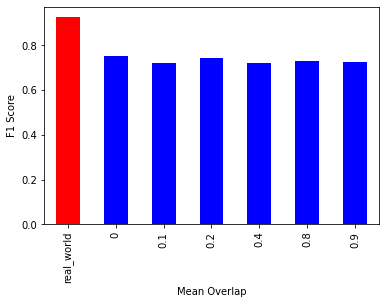

In [34]:
from matplotlib import pyplot as plt

ar_df = pd.DataFrame(all_results)
ar_df.index = pd.Series(['real_world', '0', '0.1', '0.2', '0.4', '0.8','0.9' ])
colors = ['red', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue']
ar_df.index.name = 'Mean Overlap'
ar_df
ar_df.F1.plot.bar(color=colors)
plt.ylabel('F1 Score')
plt.savefig("mutiwf.pdf", bbox_inches='tight')

In [104]:
gt_file = f"{base_dir}/{1}/combined_gt_fixed.pkl"
gt_graph = nx.read_gpickle(gt_file)
[c for c in nx.connected_components(gt_graph.to_undirected())]

[{'6_000.csv',
  '6_001.csv',
  '6_002.csv',
  '6_003.csv',
  '6_004.csv',
  '6_005.csv',
  '6_006.csv',
  '6_007.csv',
  '6_008.csv',
  '6_009.csv',
  '6_010.csv',
  '6_011.csv',
  '6_012.csv',
  '6_013.csv',
  '6_014.csv',
  '6_015.csv',
  '6_016.csv',
  '6_017.csv',
  '6_018.csv',
  '6_019.csv',
  '6_020.csv',
  '6_021.csv',
  '6_022.csv',
  '6_023.csv',
  '6_024.csv',
  '6_025.csv',
  '6_026.csv',
  '6_027.csv',
  '6_028.csv',
  '6_029.csv',
  '6_030.csv',
  '6_031.csv',
  '6_032.csv',
  '6_033.csv',
  '6_034.csv',
  '6_035.csv',
  '6_036.csv',
  '6_037.csv',
  '6_038.csv'},
 {'92_000.csv',
  '92_001.csv',
  '92_002.csv',
  '92_003.csv',
  '92_004.csv',
  '92_005.csv',
  '92_006.csv',
  '92_007.csv',
  '92_008.csv',
  '92_009.csv',
  '92_010.csv',
  '92_011.csv',
  '92_012.csv',
  '92_013.csv',
  '92_014.csv',
  '92_015.csv',
  '92_016.csv',
  '92_017.csv',
  '92_018.csv',
  '92_019.csv',
  '92_020.csv'},
 {'98_000.csv',
  '98_001.csv',
  '98_002.csv',
  '98_003.csv',
  '98_004.csv

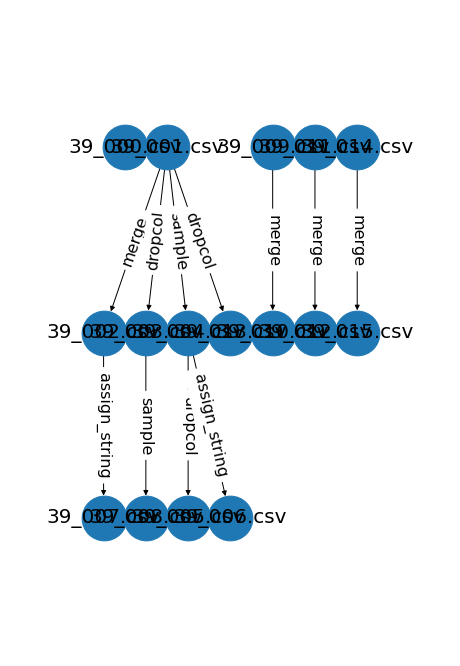

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

In [85]:
sp = 39
sp_graph_file = f"{base_dir}/{1}/graphs/{sp}_gt_fixed.pkl"
sp_gt_graph = nx.read_gpickle(sp_graph_file)
#[c for c in nx.connected_components(sp_gt_graph.to_undirected())]
draw_graph(sp_gt_graph, canvas_Size=(15,15))

In [105]:
result_df = result_df.reset_index(drop=True)
result_df

,edge,ground_truth,inferred,wf_id
0,"(90_010.csv, 90_020.csv)",True,True,1
1,"(67_006.csv, 67_000.csv)",True,True,1
2,"(26_007.csv, 26_008.csv)",True,True,1
3,"(62_028.csv, 62_014.csv)",True,True,1
4,"(45_033.csv, 45_028.csv)",True,True,1
...,...,...,...,...
8254,"(40_005.csv, 40_007.csv)",False,True,3
8255,"(62_007.csv, 62_013.csv)",False,True,3
8256,"(4_000.csv, 4_002.csv)",False,True,3
8257,"(92_034.csv, 92_008.csv)",False,True,3


In [142]:
# add graph information to the dataframe
previous_wf_id = None
for ix, row in result_df.iterrows():
    wf_id = row['wf_id']
    if wf_id != previous_wf_id:
        gt_file = f"{base_dir}/{wf_id}/combined_gt_fixed.pkl"
        relic_result = f"{base_dir}/{wf_id}/inferred_graph.csv"
        gt_graph = nx.read_gpickle(gt_file).to_undirected()
        inferred_graph = nx.read_edgelist(relic_result)
        previous_wf_id = wf_id
    
    u,v = row['edge']
    if row['ground_truth']:
        result_df.at[ix, 'operation'] = gt_graph[u][v]['operation']
    if row['inferred']:
        result_df.at[ix, 'type'] = inferred_graph[u][v]['type']
        result_df.at[ix, 'score'] = inferred_graph[u][v]['weight']
        result_df.at[ix, 'num'] = inferred_graph[u][v]['num']

result_df=result_df.loc[result_df.wf_id.isin(['1','2','3'])]

In [153]:
result_df

,edge,ground_truth,inferred,wf_id,cross_workflow,operation,type,score,num
0,"(90_010.csv, 90_020.csv)",True,True,1,False,sample,containment,0.989899,408.0
1,"(67_006.csv, 67_000.csv)",True,True,1,False,merge,groupby,2.000000,1638.0
2,"(26_007.csv, 26_008.csv)",True,True,1,False,pivot,join,1.000000,618.0
3,"(62_028.csv, 62_014.csv)",True,True,1,False,merge,join,1.000000,619.0
4,"(45_033.csv, 45_028.csv)",True,True,1,False,dropcol,groupby,1.000000,1688.0
...,...,...,...,...,...,...,...,...,...
540,"(40_005.csv, 40_007.csv)",False,True,3,False,sample,jaccard,0.900000,235.0
541,"(62_007.csv, 62_013.csv)",False,True,3,False,pivot,jaccard,0.909091,1231.0
542,"(4_000.csv, 4_002.csv)",False,True,3,False,sample,join,1.000000,640.0
543,"(92_034.csv, 92_008.csv)",False,True,3,False,merge,join,1.000000,669.0


In [143]:
TP = (result_df.ground_truth == True) & (result_df.inferred == True)
FP = (result_df.ground_truth == False) & (result_df.inferred == True)
FN = (result_df.ground_truth == True) & (result_df.inferred == False)

result_df.loc[FP].groupby(['wf_id','type']).sum()

ground_truth  inferred  cross_workflow       score  \
wf_id type                                                              
1     containment             0       137               1  135.355643   
      groupby                 0        68               0  111.000000   
      jaccard                 0       123               2  108.074143   
      join                    0       289              12  289.000000   
      pivot                   0         8               0    8.000000   
2     containment             0       141              18  139.354977   
      groupby                 0        69               6  113.000000   
      jaccard                 0       142              12  125.758759   
      join                    0       294              25  294.000000   
      pivot                   0         8               1    8.000000   
3     containment             0       126               0  124.441992   
      groupby                 0        66               0  108.000000   
      jaccard                 0        91               0   79.595479   
      join                    0       254               0  254.000000   
      pivot                   0         8               0    8.000000   

                        num  
wf_id type                   
1     containment  127553.0  
      groupby      112572.0  
      jaccard       60063.0  
      join         176325.0  
      pivot         13592.0  
2     containment  132770.0  
      groupby      114212.0  
      jaccard       75543.0  
      join         179749.0  
      pivot         13592.0  
3     containment  114095.0  
      groupby      109283.0  
      jaccard       35616.0  
      join         155689.0  
      pivot         13592.0

In [160]:
result_df.loc[TP].groupby('type').sum()
result_df.loc[FP].groupby(['wf_id','type']).sum().reset_index().pivot(index=['type'], columns='wf_id', values=['inferred','cross_workflow'])

inferred           cross_workflow       
wf_id              1    2    3              1   2  3
type                                                
containment      137  141  126              1  18  0
groupby           68   69   66              0   6  0
jaccard          123  142   91              2  12  0
join             289  294  254             12  25  0
pivot              8    8    8              0   1  0

In [155]:
result_df.loc[FN].groupby(['wf_id','operation']).sum().reset_index().pivot(index=['operation'], columns='wf_id', values=['ground_truth'])

ground_truth          
wf_id                    1    2    3
operation                           
assign_string           19   19   19
dropcol                 37   37   35
groupby                 70   70   64
merge                  192  188  170
pivot                   45   43   38
point_edit              40   40   37
sample                 150  147  135

In [157]:
result_df.loc[TP].groupby(['wf_id','type']).sum().reset_index().pivot(index=['type'], columns='wf_id', values=['ground_truth'])

ground_truth          
wf_id                  1    2    3
type                              
containment          192  192  190
groupby               73   73   73
jaccard              797  843  729
join                 553  570  531
pivot                  8    8    8

In [138]:
result_df.loc[FN].groupby('operation').sum()

,ground_truth,inferred,cross_workflow,score,num
operation,,,,,
assign_numeric,4,0,0,3.554365,5097.0
assign_string,120,0,0,121.769994,94047.0
dropcol,229,0,0,221.047007,172474.0
groupby,423,0,0,511.148595,325790.0
merge,1160,0,0,1261.923631,940110.0
pivot,265,0,0,271.354768,227552.0
point_edit,249,0,0,244.763360,161304.0
sample,906,0,0,891.375129,714470.0


<AxesSubplot:>

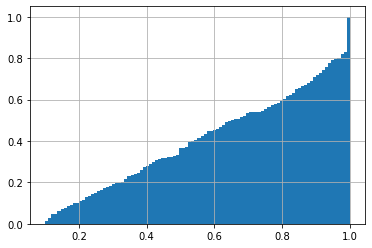

In [115]:
# Compute CDF for jaccard similarity FPS

jac_FP_scores = result_df.loc[(FP) & (result_df['type']=='jaccard') & (result_df.score <= 1.0)].sort_values('score', ascending=False)['score']
jac_FP_scores.hist(cumulative=True, density=1, bins=100)

In [133]:
# Compute CDF for jaccard similarity FPS
wf1_df = result_df.loc[result_df.wf_id == 1]
jac_FP_scores = wf1_df.loc[(FP) & (wf1_df['type']=='containment') & (wf1_df.score <= 1.0)].sort_values('score', ascending=False)['score']
jac_FP_scores.hist(cumulative=True, density=1, bins=100)

KeyError: 'type'

<AxesSubplot:>

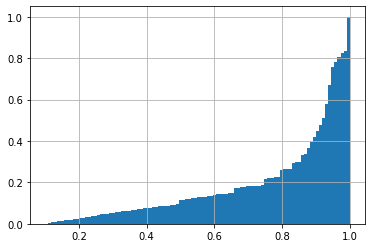

In [118]:
# Compute CDF for jaccard similarity FPS

jac_FP_scores = result_df.loc[(TP) & (result_df['type']=='jaccard') & (result_df.score <= 1.0)].sort_values('score', ascending=False)['score']
jac_FP_scores.hist(cumulative=True, density=1, bins=100)

<AxesSubplot:>

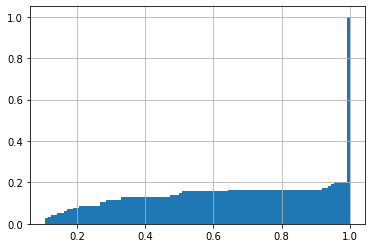

In [120]:
# Compute CDF for jaccard similarity FPS

jac_FP_scores = result_df.loc[(TP) & (result_df['type']=='containment') & (result_df.score <= 1.0)].sort_values('score', ascending=False)['score']
jac_FP_scores.hist(cumulative=True, density=1, bins=100)

In [95]:
result_df.loc[result_df['type'] == 'join']['score'].value_counts()

1.0    3329
Name: score, dtype: int64

In [96]:
ordered_joins = result_df.loc[result_df['type'] == 'join'].sort_values(['wf_id', 'num'])
ordered_joins

,edge,ground_truth,inferred,wf_id,operation,type,score,num
513,"(41_004.csv, 41_003.csv)",True,True,1,sample,join,1.0,538.0
1174,"(22_009.csv, 22_010.csv)",True,True,1,merge,join,1.0,538.0
513,"(65_001.csv, 65_023.csv)",True,False,1,sample,join,1.0,538.0
513,"(3_006.csv, 3_000.csv)",False,True,1,sample,join,1.0,538.0
326,"(9_001.csv, 9_003.csv)",True,True,1,merge,join,1.0,539.0
...,...,...,...,...,...,...,...,...
391,"(76_017.csv, 76_002.csv)",False,True,3,groupby,join,1.0,890.0
439,"(56_019.csv, 56_011.csv)",True,True,3,merge,join,1.0,891.0
1370,"(85_003.csv, 85_002.csv)",True,True,3,merge,join,1.0,891.0
439,"(22_023.csv, 22_025.csv)",True,False,3,merge,join,1.0,891.0


In [72]:
# Find join triple for each edge
#WARNING: not all join edges are correctly numbered: investigate

join_lists = pd.DataFrame(ordered_joins.groupby(['wf_id', 'num']).apply(lambda x: list(frozenset().union(*x['edge']))), columns=['edge_list'])
join_lists['ordered_edge_list'] = join_lists['edge_list'].apply(lambda x: sorted(x, key=lambda y: int(y.split('_')[1].split('.')[0])))

join_lists['list_len'] = join_lists['ordered_edge_list'].apply(lambda x: len(x))
join_lists = join_lists.loc[join_lists.list_len == 3]

join_lists['src1'] = join_lists['ordered_edge_list'].apply(lambda x: x[0])
join_lists['src2'] = join_lists['ordered_edge_list'].apply(lambda x: x[1])
join_lists['dst'] = join_lists['ordered_edge_list'].apply(lambda x: x[2])
join_lists

edge_list  \
wf_id num                                           
1     651.0     [1_022.csv, 1_021.csv, 1_014.csv]   
      652.0  [44_014.csv, 44_013.csv, 44_002.csv]   
      653.0  [93_005.csv, 93_007.csv, 93_008.csv]   
      654.0  [72_016.csv, 72_020.csv, 72_019.csv]   
      655.0  [28_001.csv, 28_002.csv, 28_000.csv]   
...                                           ...   
3     938.0  [12_000.csv, 12_038.csv, 12_037.csv]   
      939.0  [12_034.csv, 12_035.csv, 12_026.csv]   
      940.0  [44_032.csv, 44_034.csv, 44_033.csv]   
      941.0  [64_005.csv, 64_006.csv, 64_000.csv]   
      942.0  [64_001.csv, 64_005.csv, 64_006.csv]   

                                ordered_edge_list  list_len        src1  \
wf_id num                                                                 
1     651.0     [1_014.csv, 1_021.csv, 1_022.csv]         3   1_014.csv   
      652.0  [44_002.csv, 44_013.csv, 44_014.csv]         3  44_002.csv   
      653.0  [93_005.csv, 93_007.csv, 93_008.csv]         3  93_005.csv   
      654.0  [72_016.csv, 72_019.csv, 72_020.csv]         3  72_016.csv   
      655.0  [28_000.csv, 28_001.csv, 28_002.csv]         3  28_000.csv   
...                                           ...       ...         ...   
3     938.0  [12_000.csv, 12_037.csv, 12_038.csv]         3  12_000.csv   
      939.0  [12_026.csv, 12_034.csv, 12_035.csv]         3  12_026.csv   
      940.0  [44_032.csv, 44_033.csv, 44_034.csv]         3  44_032.csv   
      941.0  [64_000.csv, 64_005.csv, 64_006.csv]         3  64_000.csv   
      942.0  [64_001.csv, 64_005.csv, 64_006.csv]         3  64_001.csv   

                   src2         dst  
wf_id num                            
1     651.0   1_021.csv   1_022.csv  
      652.0  44_013.csv  44_014.csv  
      653.0  93_007.csv  93_008.csv  
      654.0  72_019.csv  72_020.csv  
      655.0  28_001.csv  28_002.csv  
...                 ...         ...  
3     938.0  12_037.csv  12_038.csv  
      939.0  12_034.csv  12_035.csv  
      940.0  44_033.csv  44_034.csv  
      941.0  64_005.csv  64_006.csv  
      942.0  64_005.csv  64_006.csv  

[978 rows x 6 columns]

In [74]:
join_lists.groupby(['wf_id','dst']).count()['edge_list'].value_countsnts()

1    856
2     52
3      6
Name: edge_list, dtype: int64

In [131]:
def split_compare(fset):
    x,y = fset
    return x.split('_')[0] != y.split('_')[0]

result_df['cross_workflow'] = result_df['edge'].apply(lambda x: split_compare(x))
result_df.groupby('wf_id').sum()['cross_workflow']

wf_id
1    15
2    62
3     0
4     3
5    62
6     0
Name: cross_workflow, dtype: int64